In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from collections import Counter
import re, nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import folium
from matplotlib.colors import LinearSegmentedColormap
import missingno as msno
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Hotel_Reviews.csv



# **About the Dataset**

This dataset contains **515,738  customer reviews** and scoring of **1493  Luxury Hotels** across Europe.
The csv file contains 17 fields. The description of each field is as below:

* **Hotel_Address**: Address of hotel.
* **Review_Date**: Date when reviewer posted the corresponding review.
* **Average_Score**: Average Score of the hotel, calculated based on the latest comment in the last year.
* **Hotel_Name**: Name of Hotel
* **Reviewer_Nationality**: Nationality of Reviewer
* **Negative_Review**: Negative Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Negative'
* **Review_Total_Negative_Word_Counts**: Total number of words in the negative review.
* **Positive_Review**: Positive Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Positive'
* **Review_Total_Positive_Word_Counts**: Total number of words in the positive review.
* **Reviewer_Score**: Score the reviewer has given to the hotel, based on his/her experience
* **Total_Number_of_Reviews_Reviewer_Has_Given**: Number of Reviews the reviewers has given in the past.
* **Total_Number_of_Reviews**: Total number of valid reviews the hotel has.
* **Tags**: Tags reviewer gave the hotel.
* **days_since_review**: Duration between the review date and scrape date.
* **Additional_Number_of_Scoring**: There are also some guests who just made a scoring on the service rather than a review. This number indicates how many valid scores without review in there.
* **lat**: Latitude of the hotel
* **lng**: longtitude of the hotel


Meanwhile, the geographical location of hotels are also provided for further analysis.

In [2]:
#loading the dataset from the Hotel_reviews dataset
df = pd.read_csv("../input/Hotel_Reviews.csv")

# **Data Analysis**

In [3]:
#printing the columns names of the datset
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [4]:
#printing the shape of the dataset
df.shape

(515738, 17)

In [5]:
print ('Number of data points : ', df.shape[0], \
       '\nNumber of features:', df.shape[1])
df.head()

Number of data points :  515738 
Number of features: 17


,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


## **Data Cleaning : Deduplication**

In [6]:
#Removing duplicates from the dataset
print(sum(df.duplicated()))
df = df.drop_duplicates()
print('After removing Duplicates: {}'.format(df.shape))

526
After removing Duplicates: (515212, 17)


* We observe that **526** reviews are **duplicate** and we removed them.

** Basic stats for the feature: Hotel_Name**

In [7]:
df.Hotel_Name.describe()

count                                         515212
unique                                          1492
top       Britannia International Hotel Canary Wharf
freq                                            4789
Name: Hotel_Name, dtype: object

* There are **1492** Hotel Names and the most reviewed Hotel is **Britannia International Hotel Canary Wharf** with **4789** reviews.

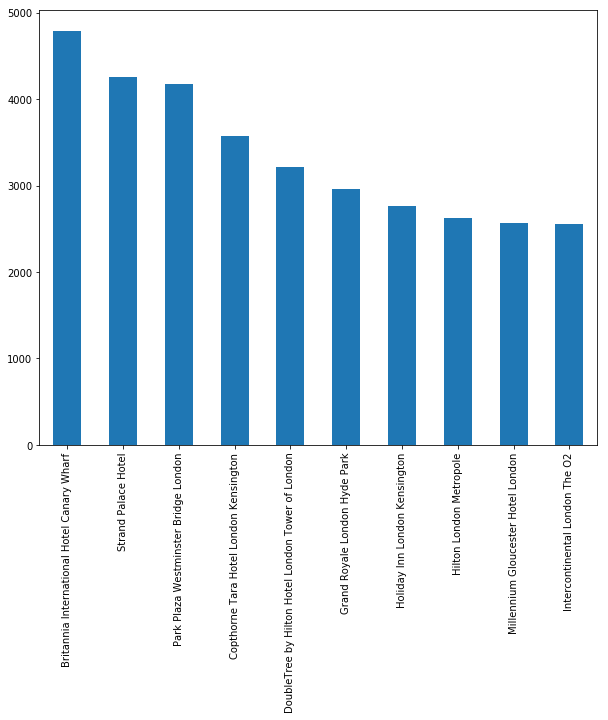

In [8]:
# Let's look at the top 10 reviewed Hotels
Hotel_Name_count = df.Hotel_Name.value_counts()
Hotel_Name_count[:10].plot(kind='bar',figsize=(10,8))

**Basic stats for the feature: Average_Score**

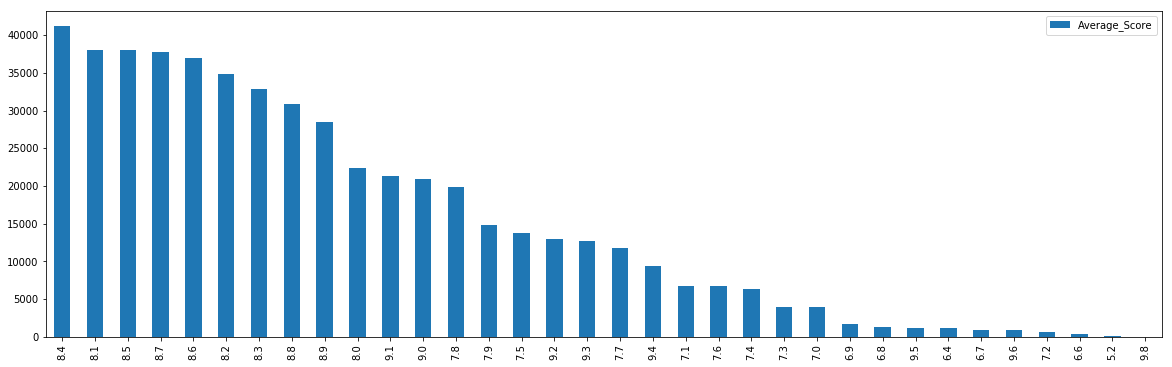

In [9]:
df.Average_Score.value_counts().plot(kind='bar',legend=True,figsize=(20,6))

In [10]:
df.Average_Score.mean()

8.397766938654277

* **we see that almost all hotels got a mean value of 8.3 Rating of the last comment in the last year**

**Basic stats for the feature: Review_Nationality**

In [11]:
df.Reviewer_Nationality.describe()

count               515212
unique                 227
top        United Kingdom 
freq                245110
Name: Reviewer_Nationality, dtype: object

 United Kingdom               245110
 United States of America      35349
 Australia                     21648
 Ireland                       14814
 United Arab Emirates          10229
 Saudi Arabia                   8940
 Netherlands                    8757
 Switzerland                    8669
 Germany                        7929
 Canada                         7883
Name: Reviewer_Nationality, dtype: int64


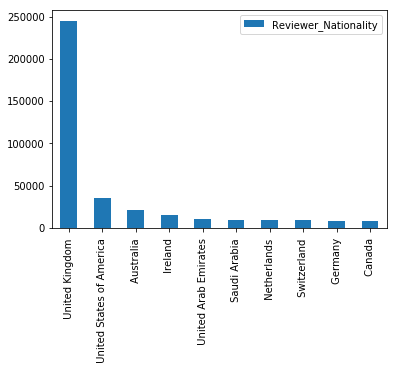

In [12]:
# Let's look at the Top 10 Reviewer's Nationalities
Reviewer_Nat_Count = df.Reviewer_Nationality.value_counts()
print(Reviewer_Nat_Count[:10])
Reviewer_Nat_Count[:10].plot(kind='bar',legend=True)

### The Reviewers belongs to **227** different countries and almost  **47.57%(245110/515212)** of Reviewers are from **United Kingdom**

**Basic stats for the feature: Review_Date**

In [13]:
df.Review_Date.describe()

count       515212
unique         731
top       8/2/2017
freq          2584
Name: Review_Date, dtype: object

*  There Reviews are given on **731 dates** and the most Reviews are given on **8/2/2017**

In [14]:
# Let's look at the top 10 Reviews given dates
Review_Date_count = df.Review_Date.value_counts()
Review_Date_count[:10]

8/2/2017     2584
9/15/2016    2304
4/5/2017     2284
8/30/2016    1959
2/16/2016    1939
7/5/2016     1903
5/31/2016    1859
12/5/2016    1801
7/12/2016    1800
8/2/2016     1781
Name: Review_Date, dtype: int64

 **Basic stats for the feature: Total_Number_of_Reviews_Reviewer_Has_Given	**

In [15]:
Reviewers_freq = df.Total_Number_of_Reviews_Reviewer_Has_Given.value_counts()
Reviewers_freq[:10]

1     154506
2      67011
3      46802
4      34991
5      27604
6      22593
7      18599
8      16126
9      13526
10     11702
Name: Total_Number_of_Reviews_Reviewer_Has_Given, dtype: int64

 * We see that almost **29.99%**  (154506 / 515212)  of user's reviewed for the **first_time**.

 **Basic stats for the feature: Review_Total_Positive_Word_Counts	**

In [16]:
pos_words = df.Review_Total_Positive_Word_Counts.value_counts()
pos_words[:10]

0     35904
6     26887
5     26809
4     24624
7     24517
8     23219
3     22505
9     21188
2     20905
10    19597
Name: Review_Total_Positive_Word_Counts, dtype: int64

*  we see that **0** words are more in number it means they are completely **Negative reviews**. Lets have a look at them.

In [17]:
a = df.loc[df.Review_Total_Positive_Word_Counts == 0]
print('No of completely Negative reviews in the dataset',len(a))
a[['Positive_Review','Negative_Review']]

No of completely Negative reviews in the dataset 35904


,Positive_Review,Negative_Review
8,No Positive,Even though the pictures show very clean room...
32,No Positive,Our bathroom had an urine order Shower was ve...
98,No Positive,Got charged 50 for a birthday package when it...
121,No Positive,The first room had steep steps to a loft bed ...
134,No Positive,Foyer was a mess Only place to relax was the ...
146,No Positive,We booked a 3 night stay in a suite On arriva...
169,No Positive,Nothing One Of The Receptionist she did a rac...
172,No Positive,Hotel under sonstruction which we weren t awa...
202,No Positive,Renovation around the hotel sometimes can sta...
209,No Positive,Not given the room type we had booked and pre...


* We see that the word count '0' in positive reviews are filled with the text **No Positive**

 **Basic stats for the feature: Review_Total_Negative_Word_Counts	**

In [18]:
neg_words = df.Review_Total_Negative_Word_Counts.value_counts()
neg_words[:10]

0     127757
2      24631
3      18126
6      17726
5      16788
7      16123
4      15049
8      14709
9      13623
10     12409
Name: Review_Total_Negative_Word_Counts, dtype: int64

*  we see that **0** words are more in number it means they are completely **Positive reviews**. Lets have a look at them.

In [19]:
a = df.loc[df.Review_Total_Negative_Word_Counts == 0 ]
print('No of completely positive reviews in the dataset:',len(a))
a[['Positive_Review','Negative_Review']]

No of completely positive reviews in the dataset: 127757


,Positive_Review,Negative_Review
1,No real complaints the hotel was great great ...,No Negative
13,This hotel is being renovated with great care...,No Negative
15,This hotel is awesome I took it sincirely bec...,No Negative
18,Public areas are lovely and the room was nice...,No Negative
48,The quality of the hotel was brilliant and ev...,No Negative
53,Beautiful setting in a lovely park room very ...,No Negative
55,The hotel is lovely and the staff were amazin...,No Negative
59,Basically everything The style of the hotel i...,No Negative
75,The whole hotel was very clean the staff were...,No Negative
78,Hotel was really nice staff were very friendl...,No Negative


* We see that the word count '0' in negative reviews**** are filled with the text **No Negative**

### **Checking for the missing values in the dataset.**

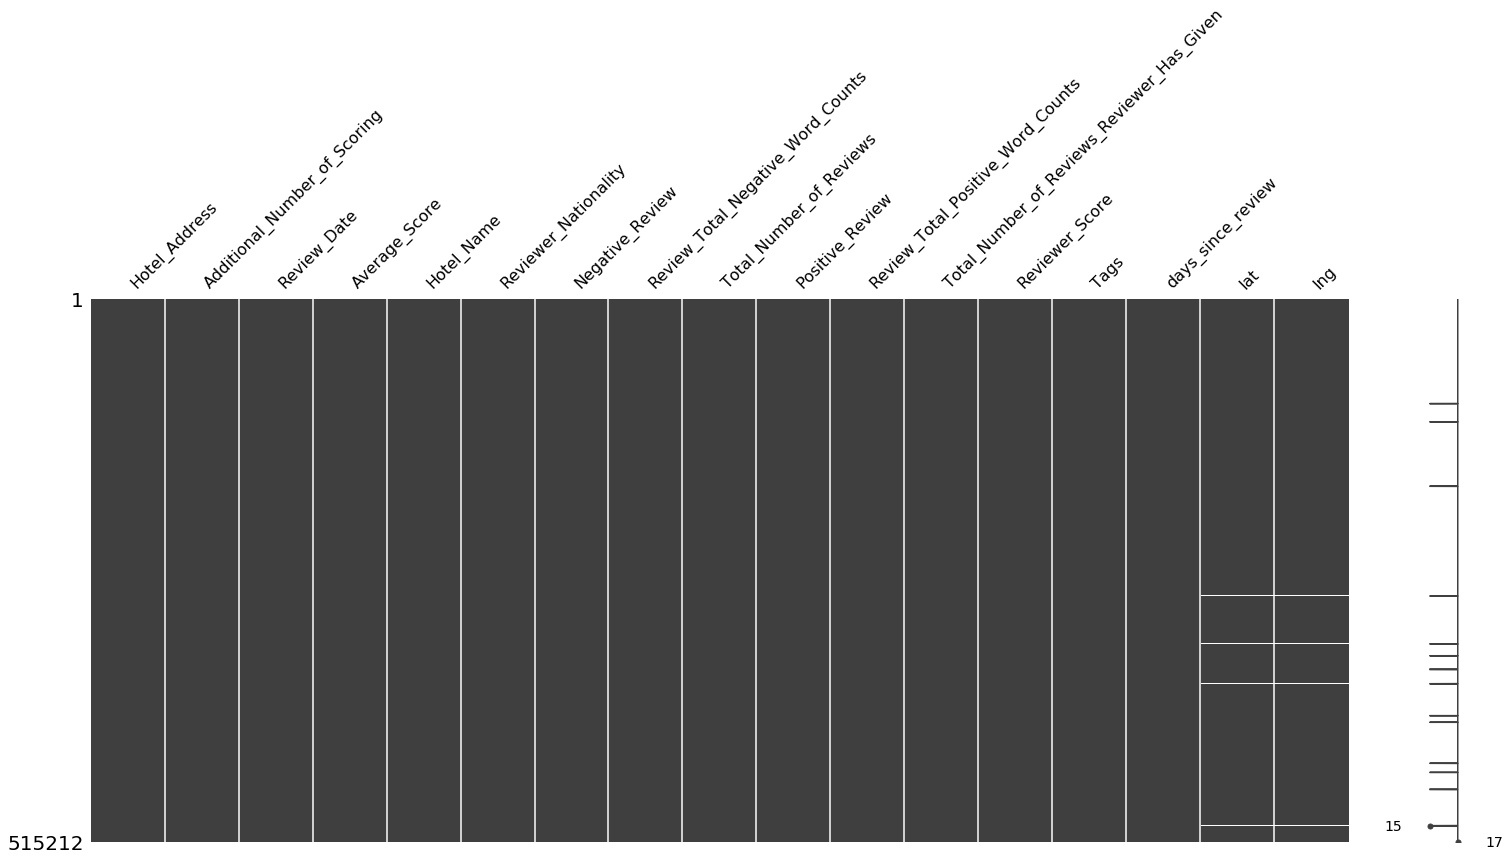

In [20]:
msno.matrix(df)

*  ### From the above plot we can see that there are some missing values in  **lat**(Latitude) and **lng**(Longitude) features  in the dataset. 
* ### Lets look at the missing values in the dataset.

In [21]:
nans = lambda df: df[df.isnull().any(axis=1)]
nans_df = nans(df)
nans_df = nans_df[['Hotel_Name','lat','lng']]
print('No of missing values in the dataset: {}'.format(len(nans_df)))

No of missing values in the dataset: 3268


In [22]:
nans_df.Hotel_Name.describe()

count                                    3268
unique                                     17
top       Fleming s Selection Hotel Wien City
freq                                      658
Name: Hotel_Name, dtype: object

* We see that there are about **3268  Nan** (missing values) from  **17**  Hotels  **lat,lng** information is not available in the dataset.
* i.e., **1.13%** of **Hotels** lat,lng information is missing.

In [23]:
# let's look at the reviews frequency of the missing Hotels.
nans_df.Hotel_Name.value_counts()

Fleming s Selection Hotel Wien City                 658
Hotel City Central                                  563
Hotel Atlanta                                       389
Maison Albar Hotel Paris Op ra Diamond              290
Hotel Daniel Vienna                                 245
Hotel Pension Baron am Schottentor                  223
Austria Trend Hotel Schloss Wilhelminenberg Wien    194
Derag Livinghotel Kaiser Franz Joseph Vienna        147
NH Collection Barcelona Podium                      146
City Hotel Deutschmeister                            93
Hotel Park Villa                                     61
Cordial Theaterhotel Wien                            57
Holiday Inn Paris Montmartre                         55
Roomz Vienna                                         49
Mercure Paris Gare Montparnasse                      37
Renaissance Barcelona Hotel                          33
Hotel Advance                                        28
Name: Hotel_Name, dtype: int64

* Instead of removing the **Nan** values from the dataset,
Try to fill the **Nan** values with the similar **Hotel_Addresses *lat, lng* values**  in the dataset. 
If the **Hotel_Address** is matched with the other rows(i.e Nan valued rows) in the dataset, Fill the **Nan** values in the dataset with the matched values(i.e., **lat**,**lng**).
* Let's look into the datset to find the similar Hotel information is availble.

In [24]:
print('No of reviews in the dataset to that Hotel:')
print('Fleming s Selection Hotel Wien City: {}'.format(len(df.loc[df.Hotel_Name == 'Fleming s Selection Hotel Wien City'])))
print('Hotel City Central: {}'.format(len(df.loc[df.Hotel_Name == 'Hotel City Central'])))
print('Hotel Atlanta: {}'.format(len(df.loc[df.Hotel_Name == 'Hotel Atlanta'])))
print('Maison Albar Hotel Paris Op ra Diamond: {}'.format(len(df.loc[df.Hotel_Name == 'Maison Albar Hotel Paris Op ra Diamond'])))
print('Hotel Daniel Vienna: {}'.format(len(df.loc[df.Hotel_Name == 'Hotel Daniel Vienna'])))
print('Hotel Pension Baron am Schottentor: {}'.format(len(df.loc[df.Hotel_Name == 'Hotel Pension Baron am Schottentor'])))
print('Austria Trend Hotel Schloss Wilhelminenberg Wien: {}'.format(len(df.loc[df.Hotel_Name == 'Austria Trend Hotel Schloss Wilhelminenberg Wien'])))
print('Derag Livinghotel Kaiser Franz Joseph Vienna: {}'.format(len(df.loc[df.Hotel_Name == 'Derag Livinghotel Kaiser Franz Joseph Vienna'])))
print('NH Collection Barcelona Podium: {}'.format(len(df.loc[df.Hotel_Name == 'NH Collection Barcelona Podium'])))
print('City Hotel Deutschmeister: {}'.format(len(df.loc[df.Hotel_Name == 'City Hotel Deutschmeister'])))
print('Hotel Park Villa: {}'.format(len(df.loc[df.Hotel_Name == 'Hotel Park Villa'])))
print('Cordial Theaterhotel Wien: {}'.format(len(df.loc[df.Hotel_Name == 'Cordial Theaterhotel Wien'])))
print('Holiday Inn Paris Montmartre: {}'.format(len(df.loc[df.Hotel_Name == 'Holiday Inn Paris Montmartre'])))
print('Roomz Vienna: {}'.format(len(df.loc[df.Hotel_Name == 'Roomz Vienna'])))
print('Mercure Paris Gare Montparnasse: {}'.format(len(df.loc[df.Hotel_Name == 'Mercure Paris Gare Montparnasse'])))
print('Renaissance Barcelona Hotel: {}'.format(len(df.loc[df.Hotel_Name == 'Renaissance Barcelona Hotel'])))
print('Hotel Advance: {}'.format(len(df.loc[df.Hotel_Name == 'Hotel Advance'])))

No of reviews in the dataset to that Hotel:
Fleming s Selection Hotel Wien City: 658
Hotel City Central: 563
Hotel Atlanta: 389
Maison Albar Hotel Paris Op ra Diamond: 290
Hotel Daniel Vienna: 245
Hotel Pension Baron am Schottentor: 223
Austria Trend Hotel Schloss Wilhelminenberg Wien: 194
Derag Livinghotel Kaiser Franz Joseph Vienna: 147
NH Collection Barcelona Podium: 146
City Hotel Deutschmeister: 93
Hotel Park Villa: 61
Cordial Theaterhotel Wien: 57
Holiday Inn Paris Montmartre: 55
Roomz Vienna: 49
Mercure Paris Gare Montparnasse: 37
Renaissance Barcelona Hotel: 33
Hotel Advance: 28


* From the above figures we see that the missing values and available values in the dataset are same.(i.e the inflat,lng values are not available in the entire dataset).
* So, Now we can fill the **NaN** values in the dataset manually. (Simply we can ignore those rows in the dataset by removing them. But i decided not to delete the information and fill the **lat,lng** values manually just because when it comes to Business problem if i try to remove the data i am losing information of 17 Hotel's. It seems like losing our 17 clients.)

For filling the **lat,lng** information of Hotel's i used this site [http://latlong.org/].

In [25]:
#latitude information of Hotels
loc_lat = {'Fleming s Selection Hotel Wien City':48.209270,
       'Hotel City Central':48.2136,
       'Hotel Atlanta':48.210033,
       'Maison Albar Hotel Paris Op ra Diamond':48.875343,
       'Hotel Daniel Vienna':48.1888,
       'Hotel Pension Baron am Schottentor':48.216701,
      'Austria Trend Hotel Schloss Wilhelminenberg Wien':48.2195,
      'Derag Livinghotel Kaiser Franz Joseph Vienna':48.245998,
      'NH Collection Barcelona Podium':41.3916,
      'City Hotel Deutschmeister':48.22088,
      'Hotel Park Villa':48.233577,
      'Cordial Theaterhotel Wien':48.209488,
      'Holiday Inn Paris Montmartre':48.888920,
      'Roomz Vienna':48.186605,
      'Mercure Paris Gare Montparnasse':48.840012,
      'Renaissance Barcelona Hotel':41.392673,
      'Hotel Advance':41.383308}

In [26]:
#longitude information of Hotels
loc_lng ={'Fleming s Selection Hotel Wien City':16.353479,
       'Hotel City Central':16.3799,
       'Hotel Atlanta':16.363449,
       'Maison Albar Hotel Paris Op ra Diamond':2.323358,
       'Hotel Daniel Vienna':16.3840,
       'Hotel Pension Baron am Schottentor':16.359819,
      'Austria Trend Hotel Schloss Wilhelminenberg Wien':16.2856,
      'Derag Livinghotel Kaiser Franz Joseph Vienna':16.341080,
      'NH Collection Barcelona Podium':2.1779,
      'City Hotel Deutschmeister':16.36663,
      'Hotel Park Villa':16.345682,
      'Cordial Theaterhotel Wien':16.351585,
      'Holiday Inn Paris Montmartre':2.333087,
      'Roomz Vienna':16.420643,
      'Mercure Paris Gare Montparnasse':2.323595,
      'Renaissance Barcelona Hotel':2.167494,
      'Hotel Advance':2.162828}

In [27]:
#filling the latitude information
df['lat'] = df['lat'].fillna(df['Hotel_Name'].apply(lambda x: loc_lat.get(x)))
#filling longitude information
df['lng'] = df['lng'].fillna(df['Hotel_Name'].apply(lambda x: loc_lng.get(x)))

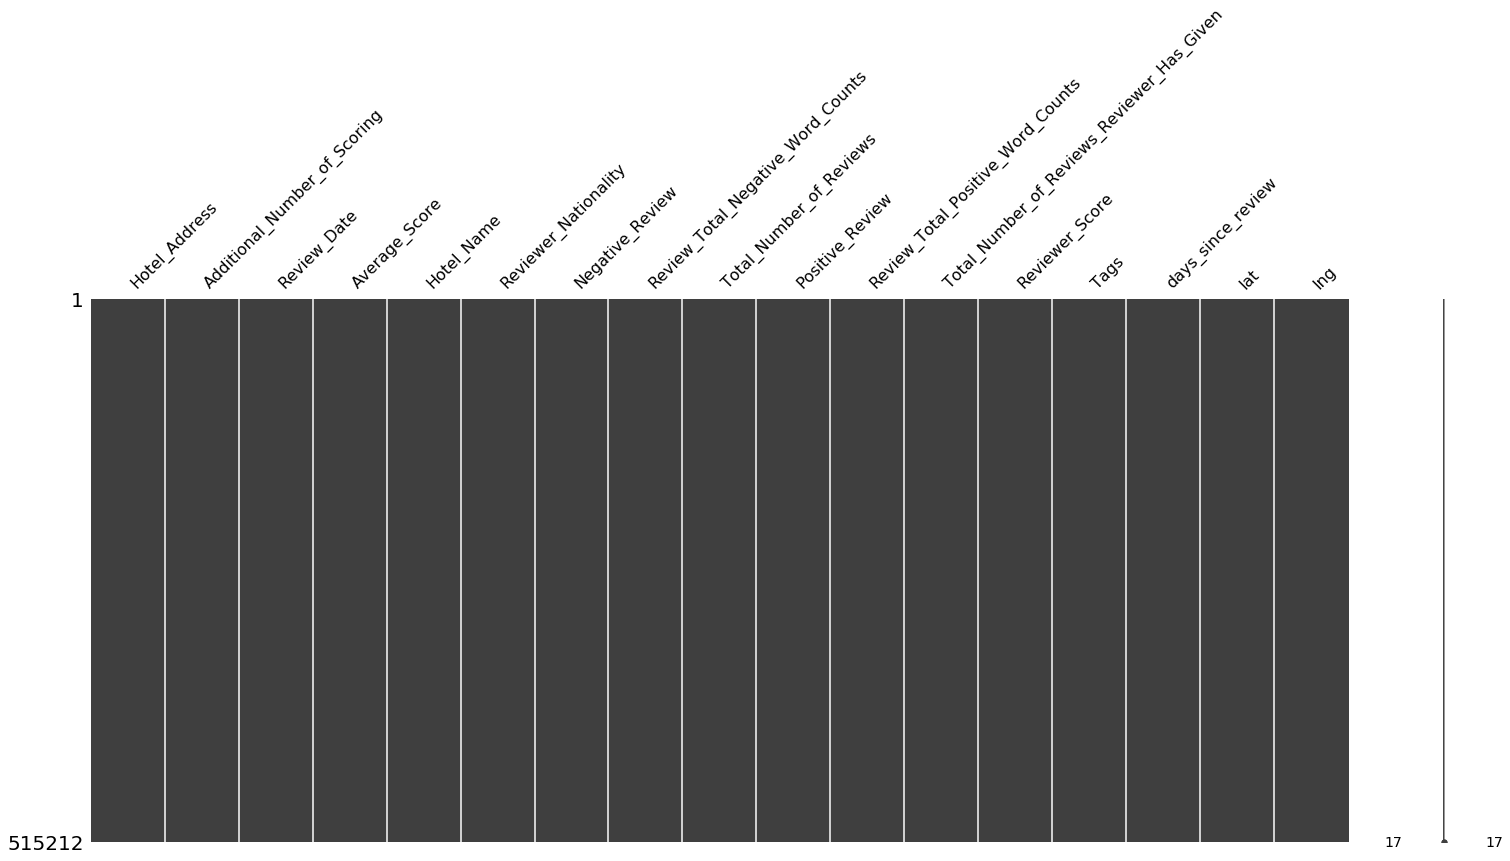

In [28]:
#looking whether information is correctly filled or not.
msno.matrix(df)

In [29]:
#saving the data to pickle files
df.to_pickle('After_filling_Nans')

In [30]:
#loading the data from the pickle file
df = pd.read_pickle('After_filling_Nans')

###  Let's plot interactive map visualitation inorder to see where the Hotels are located.
* we are using the beautiful map visualization library called folium. (if you want to know more about folium library check out this link    https://media.readthedocs.org/pdf/folium/latest/folium.pdf )

In [31]:
#Loading the unique Hotel's information to plot them on the map
temp_df = df.drop_duplicates(['Hotel_Name'])
len(temp_df)

1492

In [32]:
map_osm = folium.Map(location=[47, 6], zoom_start=5, tiles = 'Stamen Toner' )

temp_df.apply(lambda row:folium.Marker(location=[row["lat"], row["lng"]])
                                             .add_to(map_osm), axis=1)

map_osm

**Observations:**
* From the map we can see all the 1492 Hotels are located in 6 cities (Bercelona, Paris, Milan, Vienna, London, Amsterdam).         

# ** Preprocessing:**

since the dataset has already removed the unicode and punctuation in the text data and transformed text into lower case....
Half of the work of preprocessing is done. Let's do the remaining preprocessing tasks like removing stopwords, stemming.

In [33]:
#loading the positive reviews and negative reviews to a single column as text
pos_reviews = df['Positive_Review'].values
pos_reviews = pos_reviews.tolist()
neg_reviews = df['Negative_Review'].values
neg_reviews = neg_reviews.tolist()
text = pos_reviews+neg_reviews

In [34]:
#providing score attribute to the review
score = ['positive' for i in range(len(pos_reviews))]
score += ['negative' for i in range(len(neg_reviews))]
#performing one-hot encoding to the score attrubute.(1- positive and 0- negative)
for i in range(0,len(score)):
    if score[i] == 'positive':
        score[i] = 1
    else:
        score[i] = 0

In [35]:
#loading required data to dataframe.
text_df = pd.DataFrame()
text_df['reviews'] = text
text_df['score'] = score
text_df.head()

,reviews,score
0,Only the park outside of the hotel was beauti...,1
1,No real complaints the hotel was great great ...,1
2,Location was good and staff were ok It is cut...,1
3,Great location in nice surroundings the bar a...,1
4,Amazing location and building Romantic setting,1


In [36]:
# Perfoming preprocessing
start_time = time.time()
text = text_df['reviews'].values
print("Removing stop words...........................")
stop = set(stopwords.words('english'))
words = []
summary = []
all_pos_words = []
all_neg_words = []
for i in range(0,len(text)):
    if type(text[i]) == type('') :
        text[i] = text[i].lower()
        sentence = text[i]
        #Remove non-letters
        sentence = re.sub("[^a-zA-Z]"," ", sentence)
        buffer_sentence = [i for i in sentence.split() if i not in stop]
        word = ''
        for j in buffer_sentence:
            if len(j) >= 2:
                if i<=(len(text)/2): 
                    all_pos_words.append(j)
                else:
                    all_neg_words.append(j)
                word +=' '+j
        summary.append(word)
    
print("performing stemming............................")
porter = PorterStemmer()
for i in range(0,len(summary)):
    summary[i] = porter.stem(summary[i])
print("--- %s seconds ---" % (time.time() - start_time))

Removing stop words...........................
performing stemming............................
--- 46.66647744178772 seconds ---


In [37]:
len(all_pos_words),len(all_neg_words)

(4942031, 4580510)

In [38]:
freq_dist_pos = Counter(all_pos_words)
freq_dist_neg = Counter(all_neg_words)
print('Most common positive words : ',freq_dist_pos.most_common(20))
print('Most common negative words : ',freq_dist_neg.most_common(20))

Most common positive words :  [('staff', 194387), ('location', 192645), ('room', 140651), ('hotel', 125218), ('good', 112201), ('great', 105531), ('friendly', 85273), ('breakfast', 84524), ('helpful', 76102), ('nice', 69379), ('clean', 66859), ('excellent', 62229), ('comfortable', 59903), ('bed', 49881), ('rooms', 40325), ('positive', 36445), ('lovely', 35073), ('stay', 32008), ('close', 30936), ('station', 29262)]
Most common negative words :  [('room', 175835), ('negative', 129312), ('hotel', 74625), ('breakfast', 58410), ('small', 49837), ('staff', 39467), ('nothing', 38737), ('rooms', 34776), ('would', 32264), ('could', 32046), ('bed', 29819), ('one', 28054), ('bit', 27521), ('bathroom', 26568), ('night', 24071), ('little', 22520), ('like', 22433), ('shower', 21283), ('good', 20789), ('us', 20216)]


In [39]:
#unique positive and negative words
len(freq_dist_neg),len(freq_dist_pos)

(51879, 48933)

In [40]:
summary = np.array(summary)
score = text_df['score'].values

In [41]:
text_df = pd.DataFrame()
text_df['Summary'] = summary
text_df['score'] = score
text_df.to_pickle('text_df')